<a href="https://colab.research.google.com/github/mklasby/automl_tutorial/blob/master/automl_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ENEL 645 - Deep Learning
## AutoML & HPO Tutorial
- By: Mike Lasby
- 2023-03-23

In [ ]:
%%bash
pip install tpot autokeras ray[tune] keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached ray-2.3.0-cp39-cp39-manylinux2014_x86_64.whl (58.6 MB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
  Using cached virtualenv-20.21.0-py3-none-any.whl (8.7 MB)
  Using cached frozenlist-1.3.3-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (158 kB)
  Using cached tensorboardX-2.6-py2.py3-none-any.whl (114 kB)
  Using cached distlib-0.3.6-py2.py3-none-any.whl (468 kB)


In [ ]:
%matplotlib inline

In [ ]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import math
import pathlib
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
# Notebook constants that we will return to 
# TODO: What is name mangling? 
# TODO: Benefits of pathlib?
__DATA_PATH = pathlib.Path("./data")
__RANDOM_STATE = 42

### AutoML with TPOT
http://epistasislab.github.io/tpot/

TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming.


In [ ]:
X, y = load_iris(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=__RANDOM_STATE)
X_train.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
81,5.5,2.4,3.7,1.0
133,6.3,2.8,5.1,1.5
137,6.4,3.1,5.5,1.8
75,6.6,3.0,4.4,1.4
109,7.2,3.6,6.1,2.5


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(random_state=__RANDOM_STATE, n_components=2)
X_pca = pca.fit_transform(X)
df = pd.DataFrame(np.concatenate((X_pca, y.values.reshape(-1,1)), axis=1),
                  columns=[
                      "Principal component 1",
                      "Principal component 2",
                      "Label",
                  ],
).astype({"Label": "category"})
fig = px.scatter(df, x="Principal component 1", y="Principal component 2", color="Label")
fig.update_layout(title="PCA of Iris Dataset", title_x=0.5)
fig.update_xaxes(title="Principal Component 1")
fig.update_yaxes(title="Principal Component 2")
fig.show()

# TODO: What does the position of the components signify?

In [ ]:
from tpot import TPOTClassifier
classifier = TPOTClassifier(
    n_jobs=-1,   # Use all availabe cores
    scoring='accuracy',
    max_time_mins=5,  # Can set max time limit
    random_state=__RANDOM_STATE, 
    verbosity=2, 
)
classifier.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9619047619047618

2.07 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: MLPClassifier(input_matrix, alpha=0.0001, learning_rate_init=0.001)


TPOTClassifier(max_time_mins=2, n_jobs=-1, random_state=42, scoring='accuracy',
               verbosity=2)

In [ ]:
acc = classifier.score(X_test, y_test)
print(f"Accuracy score with TPOT classifier: {acc*100:.2f}%")
classifier.export("./exported_tpot_model.py")

Accuracy score with TPOT classifier: 100.00%


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_scorer.py:794: FutureWarning:

sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.



### AutoML with AutoKeras
Theory: https://arxiv.org/abs/1806.10282

"Framework enabling Bayesian optimization to guide the network morphism for efficient neural architecture search. The framework develops a neural network kernel and a tree-structured acquisition function optimization algorithm to efficiently explores the search space. Intensive experiments on real-world benchmark datasets have been done to demonstrate the superior performance of the developed framework over the state-of-the-art methods. Moreover, we build an opensource AutoML system based on our method, namely Auto-Keras."

"The system runs in parallel on CPU and GPU, with an adaptive search strategy for different GPU memory limits."

API: https://autokeras.com/

In [ ]:
import autokeras as ak
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train_tiny, _, y_train_tiny, _ = train_test_split(
  X_train, y_train, train_size=0.1,
  random_state=__RANDOM_STATE
  )

# We will search over 5000 training images only.
# Then we can fine-tune the best model using entire dataset. 
# TODO: This is an example of _____? architecture evaluation. 

"""
  | Label | Description |
  |:-----:|-------------|
  |   0   | airplane    |
  |   1   | automobile  |
  |   2   | bird        |
  |   3   | cat         |
  |   4   | deer        |
  |   5   | dog         |
  |   6   | frog        |
  |   7   | horse       |
  |   8   | ship        |
  |   9   | truck       |
"""
labels = {
    0:  "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",    
    4: "deer",     
    5: "dog",    
    6: "frog",     
    7: "horse",    
    8: "ship",   
    9: "truck",
}

170498071/170498071 [==============================] - 13s 0us/step


In [ ]:
pd.DataFrame(y_train_tiny).value_counts()

7    534
4    524
0    510
6    505
5    503
2    502
8    499
1    487
3    474
9    462
dtype: int64

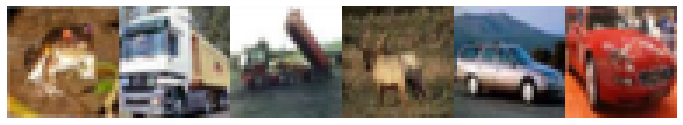

['frog', 'truck', 'truck', 'deer', 'automobile', 'automobile']


In [ ]:
from functools import reduce
# TODO: What does reduce do?
def image_row(x):
        images = tf.unstack(x)
        row = reduce(lambda a,b: tf.concat((a,b), axis=1), images)
        return row

n_images = 6
images = image_row(X_train[:n_images])
plt.figure(figsize=(12,8))
plt.imshow(images)
plt.axis("off")
plt.show()
print(f"{[labels[l] for l in y_train[:n_images].flatten()]}")

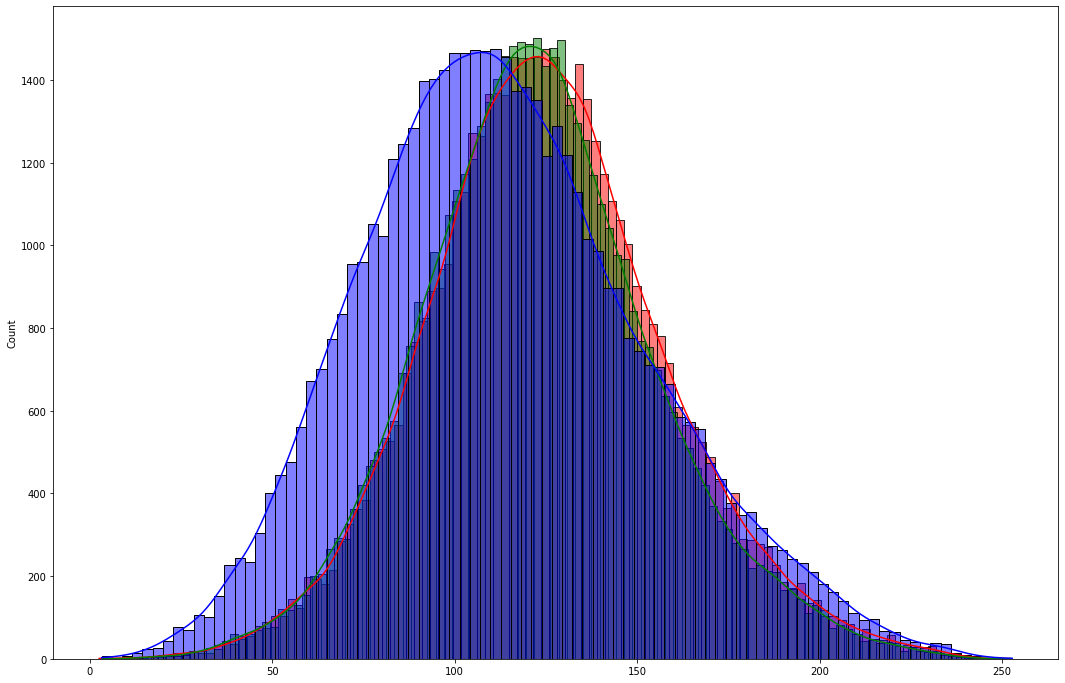

In [ ]:
plt.figure(figsize=(18,12))
# TODO: Seaborn has the best histograms
sns.histplot(X_train.mean(axis=(1,2))[:,0], kde=True, color="red")
sns.histplot(X_train.mean(axis=(1,2))[:,1], kde=True, color="green")
sns.histplot(X_train.mean(axis=(1,2))[:,2], kde=True, color="blue")
plt.show()

In [ ]:
# We will customize our search space to only consider smaller "vanilla" convolutional models
input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    # Only search Vanilla Conv architectures.
    block_type="vanilla",  # Custom block used to populate hypermodel
    # Normalize the dataset.
    normalize=True,
    # Perform augmentation
    augment=True,
)(input_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=10,
    directory= __DATA_PATH / "vanilla-conv", seed=__RANDOM_STATE, objective="val_accuracy"  # TODO: Note __truediv__ behavior of Path
)

In [ ]:
clf.fit(X_train_tiny, y_train_tiny, epochs=2)  # TODO: Fit 10 models for 5 epochs each!

Trial 10 Complete [00h 00m 25s]
val_accuracy: 0.24896694719791412

Best val_accuracy So Far: 0.3863636255264282
Total elapsed time: 00h 04m 54s


Epoch 1/2


157/157 [==============================] - 15s 76ms/step - loss: 2.0775 - accuracy: 0.2426
Epoch 2/2
157/157 [==============================] - 12s 75ms/step - loss: 1.7892 - accuracy: 0.3592


In [ ]:
trials = clf.tuner.oracle.get_best_trials(num_trials=-1)
data = {
    "Trial": [],
    "Score": []
}
for i, t in enumerate(trials):
    data["Trial"].append(i)
    data["Score"].append(t.score)
px.bar(data_frame=pd.DataFrame(data), x="Trial", y="Score")

In [ ]:
import pickle

# with open(__DATA_PATH / "vanilla-conv" / "ak_clf_van_conv.pkl", "wb") as handle:
#     pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)


# with open(__DATA_PATH / "vanilla-conv" / "ak_clf_van_conv.pkl", "rb") as handle:
#     clf = pickle.load(handle)

In [ ]:
model = clf.tuner.get_best_model()  # TODO: Take a look at the best model we found
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 32, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 32, 32, 3)        0         
 tion)                                                           
                                                             

In [ ]:
model.save(__DATA_PATH / "vanilla-conv" / "vanilla-conv-model")  # TODO: Save once your search is completed 

In [ ]:
loss, acc = clf.evaluate(X_test, y_test)
print(f"Accuracy score with AutoKeras classifier: {acc*100:.2f}%")  # Not so good, but only using 10% of data


313/313 [==============================] - 1s 4ms/step - loss: 2.2514 - accuracy: 0.2428
Accuracy score with AutoKeras classifier: 24.28%


In [ ]:
clf.export_model()  # Another option autokeras specific to export model

In [ ]:
# https://github.com/keras-team/autokeras/blob/master/autokeras/auto_model.py 
# TODO: Let's try to fine tune the best vanilla model

# See auto_model.py source, we want to make use of adapt method for auto preprocessing.

def ak_get_dataset(X,y,clf):
    x = clf._adapt(X, clf.inputs, 32)
    y = clf._adapt(y, clf._heads, 32)
    dataset = tf.data.Dataset.zip((x, y))
    pipeline = clf.tuner.get_best_pipeline()
    dataset = pipeline.transform(dataset)
    return dataset

train_split = int(0.8 * len(X_train))
train_dataset = ak_get_dataset(X_train[:train_split], y_train[:train_split], clf)
val_dataset = ak_get_dataset(X_train[train_split:], y_train[train_split:], clf)
test_dataset = ak_get_dataset(X_test, y_test, clf)

In [ ]:
# Let's try fully training for a few epochs:
# tf.config.run_functions_eagerly(True)
model = tf.keras.models.load_model(__DATA_PATH / "vanilla-conv" / "vanilla-conv-model")
history = model.fit(train_dataset, batch_size=32, epochs=10, validation_data=val_dataset)

Epoch 1/10


1250/1250 [==============================] - 97s 75ms/step - loss: 1.6914 - accuracy: 0.3822 - val_loss: 1.6193 - val_accuracy: 0.4144
Epoch 2/10
1250/1250 [==============================] - 112s 90ms/step - loss: 1.6456 - accuracy: 0.4008 - val_loss: 1.6193 - val_accuracy: 0.4144
Epoch 3/10
1250/1250 [==============================] - 97s 77ms/step - loss: 1.6458 - accuracy: 0.4043 - val_loss: 1.6193 - val_accuracy: 0.4144
Epoch 4/10
1250/1250 [==============================] - 94s 75ms/step - loss: 1.6455 - accuracy: 0.4018 - val_loss: 1.6193 - val_accuracy: 0.4144
Epoch 5/10
1250/1250 [==============================] - 93s 74ms/step - loss: 1.6472 - accuracy: 0.4016 - val_loss: 1.6193 - val_accuracy: 0.4144
Epoch 6/10
1250/1250 [==============================] - 95s 76ms/step - loss: 1.6464 - accuracy: 0.4019 - val_loss: 1.6193 - val_accuracy: 0.4144
Epoch 7/10
1250/1250 [==============================] - 94s 76ms/step - loss: 1.6451 - accuracy: 0.4004 - val_loss: 1.6193 - val_accur

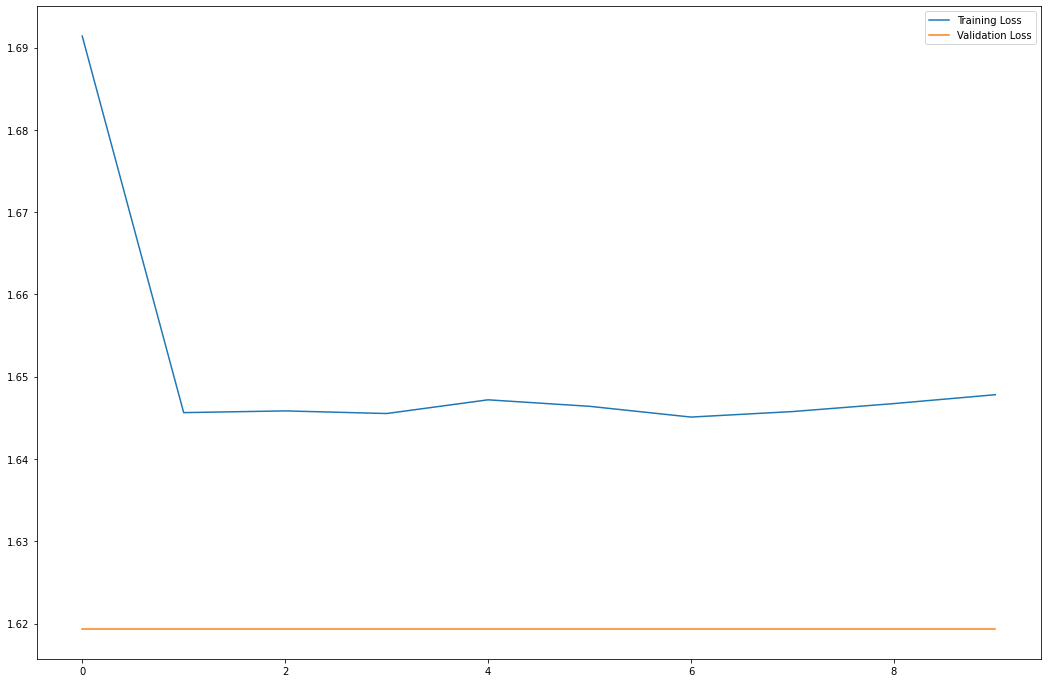

In [ ]:
plt.figure(figsize=(18,12))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(test_dataset)
acc = accuracy_score(y_test, y_pred.argmax(axis=1))
print(f"Accuracy score with AutoKeras classifier after full dataset fit: {acc*100:.2f}%")  # Better, but still not great. Perhaps we need to try a larger model? 

313/313 [==============================] - 1s 3ms/step
Accuracy score with AutoKeras classifier after full dataset fit: 40.97%


# What about larger models?


In [ ]:
from autokeras.tuners import task_specific
for hp in task_specific.IMAGE_CLASSIFIER:
    print(f"{hp}\n")
# NOTE: This is the default tuner initial hyper params. Note block types.

{'image_block_1/block_type': 'vanilla', 'image_block_1/normalize': True, 'image_block_1/augment': False, 'image_block_1/conv_block_1/kernel_size': 3, 'image_block_1/conv_block_1/num_blocks': 1, 'image_block_1/conv_block_1/num_layers': 2, 'image_block_1/conv_block_1/max_pooling': True, 'image_block_1/conv_block_1/separable': False, 'image_block_1/conv_block_1/dropout': 0.25, 'image_block_1/conv_block_1/filters_0_0': 32, 'image_block_1/conv_block_1/filters_0_1': 64, 'classification_head_1/spatial_reduction_1/reduction_type': 'flatten', 'classification_head_1/dropout': 0.5, 'optimizer': 'adam', 'learning_rate': 0.001}

{'image_block_1/block_type': 'resnet', 'image_block_1/normalize': True, 'image_block_1/augment': True, 'image_block_1/image_augmentation_1/horizontal_flip': True, 'image_block_1/image_augmentation_1/vertical_flip': True, 'image_block_1/image_augmentation_1/contrast_factor': 0.0, 'image_block_1/image_augmentation_1/rotation_factor': 0.0, 'image_block_1/image_augmentation_1/t

In [ ]:
import autokeras as ak
clf = ak.ImageClassifier(max_trials=5, directory=__DATA_PATH, seed=__RANDOM_STATE,
                         overwrite=True, objective="val_accuracy")
clf.fit(X_train_tiny, y_train_tiny, epochs=1)

Trial 5 Complete [00h 00m 19s]
val_accuracy: 0.2623966932296753

Best val_accuracy So Far: 0.43285122513771057
Total elapsed time: 00h 09m 04s
157/157 [==============================] - 2s 6ms/step - loss: 1.8490 - accuracy: 0.3394


In [ ]:
trials = clf.tuner.oracle.get_best_trials(num_trials=-1)
data = {
    "Trial": [],
    "Score": []
}
for i, t in enumerate(trials):
    data["Trial"].append(i)
    data["Score"].append(t.score)
px.bar(data_frame=pd.DataFrame(data), x="Trial", y="Score")

In [ ]:
model = clf.tuner.get_best_models()[0]
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 32, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0     

In [ ]:
# NOTE: A few more params than our vanilla model!

In [ ]:
import pickle
# with open(__DATA_PATH / "image_classifier" / "ak_clf_eff_net.pkl", "wb") as handle:
#     pickle.dump(clf, handle, protocol = pickle.HIGHEST_PROTOCOL)

# with open(__DATA_PATH / "image_classifier" / "ak_clf_eff_net.pkl", "wb") as handle:
#     clf = pickle.load(handle)

In [ ]:
clf.tuner.search_space_summary()  # NOTE: Large search space! Will take hours to days to explore fully.

Search space summary
Default search space size: 28
image_block_1/normalize (Boolean)
{'default': False, 'conditions': []}
image_block_1/augment (Boolean)
{'default': False, 'conditions': []}
image_block_1/block_type (Choice)
{'default': 'resnet', 'conditions': [], 'values': ['resnet', 'xception', 'vanilla', 'efficient'], 'ordered': False}
image_block_1/res_net_block_1/pretrained (Boolean)
{'default': False, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'image_block_1/block_type', 'values': ['resnet']}}]}
image_block_1/res_net_block_1/version (Choice)
{'default': 'resnet50', 'conditions': [{'class_name': 'Parent', 'config': {'name': 'image_block_1/block_type', 'values': ['resnet']}}], 'values': ['resnet50', 'resnet101', 'resnet152', 'resnet50_v2', 'resnet101_v2', 'resnet152_v2'], 'ordered': False}
image_block_1/res_net_block_1/imagenet_size (Boolean)
{'default': False, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'image_block_1/block_type', 'values': ['resnet'

In [ ]:
from sklearn.metrics import accuracy_score
test_dataset = ak_get_dataset(X_test, y_test, clf)
y_pred = model.predict(test_dataset)
acc = accuracy_score(y_test, y_pred.argmax(axis=1))
print(f"Accuracy score with AutoKeras-Efficient-Net classifier after full dataset fit: {acc*100:.2f}%")  # Single epoch score! 

313/313 [==============================] - 1s 2ms/step
Accuracy score with AutoKeras-Efficient-Net classifier after full dataset fit: 42.28%


### HPO with Keras Tuner

In [ ]:
clf.tuner.oracle.hyperparameters.space
# NOTE: AutoKeras and Keras Tuner are closely related. (AK depends on Keras Tuner). These hyperparameters define search space.

[Boolean(name: "image_block_1/normalize", default: False),
 Boolean(name: "image_block_1/augment", default: False),
 Choice(name: 'image_block_1/block_type', values: ['resnet', 'xception', 'vanilla', 'efficient'], ordered: False, default: resnet),
 Boolean(name: "image_block_1/res_net_block_1/pretrained", default: False),
 Choice(name: 'image_block_1/res_net_block_1/version', values: ['resnet50', 'resnet101', 'resnet152', 'resnet50_v2', 'resnet101_v2', 'resnet152_v2'], ordered: False, default: resnet50),
 Boolean(name: "image_block_1/res_net_block_1/imagenet_size", default: False),
 Choice(name: 'classification_head_1/spatial_reduction_1/reduction_type', values: ['flatten', 'global_max', 'global_avg'], ordered: False, default: flatten),
 Choice(name: 'classification_head_1/dropout', values: [0.0, 0.25, 0.5], ordered: True, default: 0),
 Choice(name: 'optimizer', values: ['adam', 'sgd', 'adam_weight_decay'], ordered: False, default: adam),
 Choice(name: 'learning_rate', values: [0.1, 0.

In [ ]:
import keras_tuner as kt

"""
NOTE: each Keras Application expects a specific kind of input preprocessing.
For EfficientNet, input preprocessing is included as part of the model (as a
Rescaling layer), and thus tf.keras.applications.efficientnet.preprocess_input
is actually a pass-through function. EfficientNet models expect their inputs to
be float tensors of pixels with values in the [0-255] range.
"""

def get_eff_net_backbone_model(units, activation, dropout, lr):
    eff_net = tf.keras.applications.efficientnet.EfficientNetB0(
        include_top=False,  # We are applying to new problem and will train our own classifier
        weights="imagenet",
        input_shape = (32,32,3),  #NHWC
        classes=10,
    )
    eff_net.trainable = False
    input = tf.keras.Input(shape=(32,32,3), name = "input")
    x = eff_net(input)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Activation(activation)(x)
    if dropout:
        x = tf.keras.layers.Dropout(rate=0.25)(x)
    x = tf.keras.layers.Dense(10)(x)
    x = tf.keras.layers.Activation("softmax")(x)
    model = tf.keras.Model(inputs=input,
                        outputs=x,
                        name="eff_net_cifar10")
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics="accuracy"
    )
    return model

def build_hypermodel(hp):
    units = hp.Int("units", min_value=32, max_value=512, step = 32)
    activation = hp.Choice("activation", ["relu", 'swish'])
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    dropout = hp.Boolean("dropout")
    model = get_eff_net_backbone_model(units, activation, dropout, lr)
    return model


model = build_hypermodel(kt.HyperParameters())
model.summary()

16705208/16705208 [==============================] - 2s 0us/step
Model: "eff_net_cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 1, 1, 1280)       4049571   
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 32)                40992     
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                    

In [ ]:
# NOTE: Lots of params, but mostly we are relying on image net weights for evaluating our different classifier heads.

In [ ]:
y_train_ohe = tf.one_hot(y_train.flatten(), 10)  # We finally need to do some work of our own!
y_test_ohe = tf.one_hot(y_test.flatten(), 10)
y_train_tiny_ohe = tf.one_hot(y_train_tiny.flatten(), 10)

In [ ]:
# TODO: Demo TF board if we have time
# tensorboard --logdir=logs --host localhost --port 8888
tf.config.run_functions_eagerly(False)
tb_callback = tf.keras.callbacks.TensorBoard("./logs")
tuner = kt.BayesianOptimization(
    hypermodel=build_hypermodel,
    max_trials=10,
    overwrite=True,
    objective="val_accuracy",
    directory = __DATA_PATH / "keras-tuner" / "test"
)

history = tuner.search(
    X_train_tiny,
    y_train_tiny_ohe,
    validation_split=0.2,
    epochs=2,
    callbacks=[tb_callback]
)

Trial 10 Complete [00h 00m 16s]
val_accuracy: 0.453000009059906

Best val_accuracy So Far: 0.47099998593330383
Total elapsed time: 00h 02m 52s


In [ ]:
tuner.results_summary()

Results summary
Results in data/keras-tuner/test/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 224
activation: relu
lr: 0.0011684126260235346
dropout: False
Score: 0.47099998593330383
Trial summary
Hyperparameters:
units: 128
activation: relu
lr: 0.0006363719363340232
dropout: False
Score: 0.45399999618530273
Trial summary
Hyperparameters:
units: 320
activation: relu
lr: 0.0009374195595247522
dropout: True
Score: 0.453000009059906
Trial summary
Hyperparameters:
units: 224
activation: relu
lr: 0.001719120591054936
dropout: True
Score: 0.4440000057220459
Trial summary
Hyperparameters:
units: 192
activation: relu
lr: 0.004713373094066093
dropout: True
Score: 0.4410000145435333
Trial summary
Hyperparameters:
units: 96
activation: swish
lr: 0.0056970903560376865
dropout: False
Score: 0.43799999356269836
Trial summary
Hyperparameters:
units: 320
activation: relu
lr: 0.0009952818649930884
dropout: True
Score: 0.4359999895095825
Trial summary
Hyperparameters:
un

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'swish'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
dropout (Boolean)
{'default': False, 'conditions': []}


In [ ]:
hp = tuner.get_best_hyperparameters()[0]
model_hp = tuner.hypermodel.build(hp)
model_hp.summary()

Model: "eff_net_cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 1, 1, 1280)       4049571   
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 224)               286944    
                                                                 
 activation_2 (Activation)   (None, 224)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                2250      
                                                                 
 activation_3 (Activation)   (None, 10)            

In [ ]:
model = tuner.get_best_models()[0]
model.summary()

Model: "eff_net_cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 1, 1, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 224)               286944    
                                                                 
 activation (Activation)     (None, 224)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2250      
                                                                 
 activation_1 (Activation)   (None, 10)            

In [ ]:
# What about preprocessing? Define custom hypermodel with fit and build methods

import keras_tuner as kt

tf.config.run_functions_eagerly(False)

class EffnetHypermodel(kt.HyperModel):
    
    def __init__(self):
        super()
        
    
    def get_eff_net_backbone_model(self, units, activation, dropout, lr):
        eff_net = tf.keras.applications.efficientnet.EfficientNetB0(
            include_top=False,  # We are applying to new problem and will train our own classifier
            weights="imagenet",
            input_shape = (32,32,3),  #NHWC
            classes=10,
        )
        eff_net.trainable = False
        input = tf.keras.Input(shape=(32,32,3), batch_size=32, name = "input")
        x = eff_net(input)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(units)(x)
        x = tf.keras.layers.Activation(activation)(x)
        if dropout:
            x = tf.keras.layers.Dropout(rate=0.25)(x)
        x = tf.keras.layers.Dense(10)(x)
        x = tf.keras.layers.Activation("softmax")(x)
        model = tf.keras.Model(inputs=input,
                            outputs=x,
                            name="eff_net_cifar10")
        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics="accuracy"
        )
        return model

    #override: This method must be implemented as it will be called by tuner / oracle
    def build(self, hp):
        units = hp.Int("units", min_value=32, max_value=512, step = 32)
        activation = hp.Choice("activation", ["relu", 'swish'])
        lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        dropout = hp.Boolean("dropout")
        model = get_eff_net_backbone_model(units, activation, dropout, lr)
        return model

    #override
    def fit(self, hp, model, x, y, **kwargs):
        if hp.Boolean("normalize"):
            x = tf.keras.layers.Normalization()(x)   # Applies to X
        y_ohe = tf.one_hot(y, 10)  # We can move ohe here -> (N, 1, 10)
        y_ohe = tf.keras.layers.Flatten()(y_ohe)  # (N, 10) to match output layer
        return model.fit(
            x,
            y_ohe,
            **kwargs,
        )

tf.config.run_functions_eagerly(True)
tb_callback = tf.keras.callbacks.TensorBoard("./logs")
tuner = kt.BayesianOptimization(
    hypermodel=EffnetHypermodel(),
    max_trials=3,
    overwrite=True,
    objective="val_accuracy",
    directory = __DATA_PATH / "keras-tuner-preprocessing"
)

history = tuner.search(
    X_train_tiny,
    y_train_tiny,  # No one-hot-encoding required
    validation_split=0.2,
    epochs=2,
    callbacks=[tb_callback]
)


Trial 3 Complete [00h 02m 26s]
val_accuracy: 0.41200000047683716

Best val_accuracy So Far: 0.46399998664855957
Total elapsed time: 00h 07m 18s


In [ ]:
# Let's check out the best model we found
hp = tuner.get_best_hyperparameters()[0]
model_hp = tuner.hypermodel.build(hp)
model_hp.summary()
        

Model: "eff_net_cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 1, 1, 1280)       4049571   
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                81984     
                                                                 
 activation_2 (Activation)   (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
 activation_3 (Activation)   (None, 10)            

### Ray Tune

Ray provides a simple, universal API for building distributed applications.

Ray accomplishes this mission by:

- Providing simple primitives for building and running distributed applications.

- Enabling end users to parallelize single machine code, with little to zero code changes.

- Including a large ecosystem of applications, libraries, and tools on top of the core Ray to enable complex applications.

White paper: https://docs.google.com/document/d/1lAy0Owi-vPz2jEqBSaHNQcy2IBSDEHyXNOQZlGuj93c/preview 

Alternative to Spark / MLLib


https://docs.ray.io/en/latest/tune/index.html

In [ ]:
from ray import tune

def loss(x, a, b):
    return a * (x ** 0.5) + b

def trainable(config):
    # config (dict): A dict of hyperparameters.
    for x in range(20):
        score = loss(x, config["a"], config["b"])
        tune.report(score=score)  # This sends the score to Tune.
        
        
config = {
    "a": tune.choice([0.1, 1, 10, 100]),
    "b": tune.uniform(1,3),

}

analysis = tune.run(trainable, config=config, local_dir = __DATA_PATH / "ray-tune",
                    num_samples=10, verbose=2)
print("best config: ", analysis.get_best_config(metric="score", mode="min"))

2023-03-23 21:20:06,172	INFO worker.py:1553 -- Started a local Ray instance.


Trial name,score
trainable_7c99b_00000,2.20166
trainable_7c99b_00001,44.9482
trainable_7c99b_00002,3.40786
trainable_7c99b_00003,3.31892
trainable_7c99b_00004,2.72443
trainable_7c99b_00005,1.53685
trainable_7c99b_00006,437.799
trainable_7c99b_00007,437.559
trainable_7c99b_00008,437.873
trainable_7c99b_00009,45.5062


2023-03-23 21:20:13,318	INFO tune.py:798 -- Total run time: 5.36 seconds (4.15 seconds for the tuning loop).


best config:  {'a': 0.1, 'b': 1.1009611608287864}


In [ ]:
px.bar(x="trial_id", y="score", data_frame=analysis.dataframe())

# We can use ray.tune with *any* machine learning library!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from ray import tune


def get_data(data_dir = __DATA_PATH / "cifar10"):  # NOTE: Providing datapath is important to share dataset between threads / nodes.
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_data = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
    test_data = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)

    # Get train, val splits
    val_data = Subset(train_data, list(range(4000,5000)))
    train_data = Subset(train_data, list(range(4000)))  # let's speed up training with low fidelity search again
    

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_data()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html

class ConvolutionalNetwork(nn.Module):
    def __init__(self, hp):
        super().__init__()
        self.conv1_width = int(hp["conv1_width"])  # Choice returns a Categorical type, so we convert to int.
        self.conv2_width = int(hp["conv2_width"])
        self.conv1 = nn.Conv2d(3, self.conv1_width, 3, 1, padding="same") # 32x32 -> 16x16
        self.conv2 = nn.Conv2d(self.conv1_width, self.conv2_width, 3, 1, padding="same")# 16x16 -> 8x8
        self.fc1 = nn.Linear(8*8*self.conv2_width, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 8*8*self.conv2_width)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [ ]:
labels = {
    0:  "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",    
    4: "deer",     
    5: "dog",    
    6: "frog",     
    7: "horse",    
    8: "ship",   
    9: "truck",
}

Label: [7 6 2 5 3 9 6 0 5 3]
Class:  horse frog bird dog cat truck frog airplane dog cat


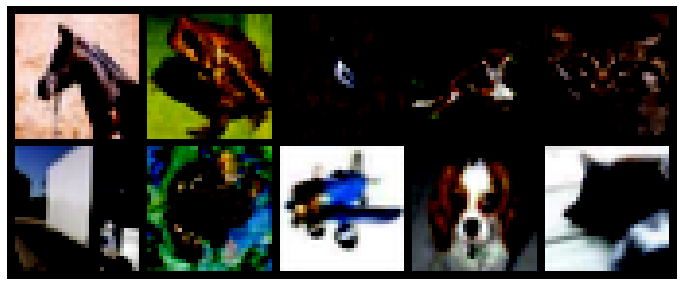

In [ ]:
from torchvision.utils import make_grid
# Grab the first batch of 32 images
for images,classes in train_loader: 
    break

# Print the labels
print('Label:', classes[:10].numpy())
print('Class: ', *np.array([labels[i.item()] for i in classes[:10]]))

# Print the images
im = make_grid(images[:10], nrow=5)  # the default nrow is 8
plt.figure(figsize=(12,6))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))  # NOTE: PyTorch image format NCHW -> Channels first!
plt.axis("off")
plt.show()

In [ ]:
print(images[0].shape) # channels first for PyTorch! matplotlib.pyplot.imshow() / TF expect NHWC

torch.Size([3, 32, 32])


In [ ]:
import time


def train_cifar(hp, data_dir):
    start_time = time.time()
    train_loader, val_loader, _ = get_data(data_dir)
    model = ConvolutionalNetwork(hp) # define a net for this run
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    epochs = hp["epochs"]
    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []

    for i in range(epochs):
        trn_corr = 0
        tst_corr = 0
        
        # Run the training batches
        for b, (X_train, y_train) in enumerate(train_loader):
            b+=1
            
            # Apply the model
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
    
            # Tally the number of correct predictions
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr
            
            # Update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Print interim results
            if b%25 == 0:
                print(f'epoch: {i:2}  batch: {b:4} loss: {loss.item():10.8f}\
                    accuracy: {trn_corr.item()*100/(32*b):7.3f}%')
            
        train_losses.append(loss)
        train_correct.append(trn_corr)
            
        # Run the testing batches
        with torch.no_grad():
            for b, (X_val, y_val) in enumerate(val_loader):

                # Apply the model
                y_pred = model(X_val)

                # Tally the number of correct predictions
                predicted = torch.max(y_pred.data, 1)[1] 
                tst_corr += (predicted == y_val).sum()
                
        loss = criterion(y_pred, y_val)
        test_losses.append(loss)
        test_correct.append(tst_corr/b)
    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  
    tune.report(loss=loss.item(), accuracy=tst_corr.item()*100/(32*b))  # Report results to ray.tune


In [ ]:
# Search Space:

hp = {
    "conv1_width": tune.choice([3,6,9]),
    "conv2_width": tune.choice([9,18]),
    "epochs": 3 # We will only use 3 epoch for this trial
}

In [ ]:
result = tune.run(
    tune.with_parameters(train_cifar, data_dir = __DATA_PATH / "cifar10"),
    config=hp,
    num_samples=3,
    local_dir = __DATA_PATH / "ray-tune",
    verbose=1
)

# NOTE: Check out that duration! Ray will multi thread when run locally 

(train_cifar pid=30164) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to data/cifar10/cifar-10-python.tar.gz


  7%|▋         | 12451840/170498071 [00:02<00:18, 8717408.71it/s]


(train_cifar pid=30216) Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to data/cifar10/cifar-10-python.tar.gz


 99%|█████████▉| 168787968/170498071 [00:13<00:00, 13725428.04it/s]


(train_cifar pid=30164) Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10


100%|██████████| 170498071/170498071 [00:13<00:00, 13007360.16it/s]


(train_cifar pid=30216) Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
(train_cifar pid=30164) Files already downloaded and verified
(train_cifar pid=30216) Files already downloaded and verified
(train_cifar pid=30164) epoch:  0  batch:   25 loss: 2.30174541                    accuracy:  10.750%
(train_cifar pid=30216) epoch:  0  batch:   25 loss: 2.23822927                    accuracy:  12.000%
(train_cifar pid=30164) epoch:  0  batch:   50 loss: 2.17816424                    accuracy:  13.812%
(train_cifar pid=30216) epoch:  0  batch:   50 loss: 2.25888133                    accuracy:  15.812%
(train_cifar pid=30164) epoch:  0  batch:   75 loss: 2.12985873                    accuracy:  16.917%
(train_cifar pid=30216) epoch:  0  batch:   75 loss: 1.92198050                    accuracy:  19.583%
(train_cifar pid=30164) epoch:  0  batch:  100 loss: 1.98142099                    accuracy:  18.750%
(train_cifar pid=30216) epoch:  0  batch:  100 loss: 1.86710393            

100%|██████████| 170498071/170498071 [00:13<00:00, 12986122.25it/s]


(train_cifar pid=30164) Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
(train_cifar pid=30164) Files already downloaded and verified
(train_cifar pid=30164) epoch:  0  batch:   25 loss: 2.34298611                    accuracy:  13.000%
(train_cifar pid=30164) epoch:  0  batch:   50 loss: 2.20724750                    accuracy:  15.125%
(train_cifar pid=30164) epoch:  0  batch:   75 loss: 1.96035409                    accuracy:  19.875%
(train_cifar pid=30164) epoch:  0  batch:  100 loss: 2.18372083                    accuracy:  21.969%
(train_cifar pid=30164) epoch:  0  batch:  125 loss: 1.97497523                    accuracy:  23.475%
(train_cifar pid=30164) epoch:  1  batch:   25 loss: 1.66555274                    accuracy:  35.000%
(train_cifar pid=30164) epoch:  1  batch:   50 loss: 1.70781028                    accuracy:  35.562%
(train_cifar pid=30164) epoch:  1  batch:   75 loss: 1.65045583                    accuracy:  36.250%
(train_cifar pid=30164) epoch:  1  

2023-03-23 21:22:04,556	INFO tune.py:798 -- Total run time: 67.80 seconds (67.76 seconds for the tuning loop).


In [ ]:
result.dataframe()

,loss,accuracy,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,...,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time,config/conv1_width,config/conv2_width,config/epochs,logdir
0,1.865014,39.415323,37.379423,False,NaN,NaN,1,99afb_00000,151e175610bf4694a28236dc40048958,2023-03-23_21-21-38,...,0d2fcdd812ec,172.28.0.12,37.379423,0,1,0.003556,9,9,3,/content/data/ray-tune/train_cifar_2023-03-23_...
1,1.254956,42.237903,35.012311,False,NaN,NaN,1,99afb_00001,a4d9b9a1d9224df5a1fd93a2eca1daa9,2023-03-23_21-21-39,...,0d2fcdd812ec,172.28.0.12,35.012311,0,1,0.004175,6,18,3,/content/data/ray-tune/train_cifar_2023-03-23_...
2,1.891581,45.362903,25.809389,False,NaN,NaN,1,99afb_00002,151e175610bf4694a28236dc40048958,2023-03-23_21-22-04,...,0d2fcdd812ec,172.28.0.12,25.809389,0,1,0.003556,9,18,3,/content/data/ray-tune/train_cifar_2023-03-23_...


In [ ]:
result.get_best_config(metric="accuracy", mode="max")

{'conv1_width': 9, 'conv2_width': 18, 'epochs': 3}